In [290]:
from pkg_req import *
from construction import *
from solver import *
from backend import *
from pulses import *
from fidelity import *
from initialization import *

Helpful info:

https://qiskit-community.github.io/qiskit-dynamics/tutorials/qiskit_pulse

https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.optimizers.ADAM.html

# Finding an optimal rotation pulse to rotate a qubit from |0> to |1>

1 qubit density matrix when in the |1> state:

In [291]:
des_state=np.zeros((2,2), dtype=complex)
des_state[1, 1]=1
des_state=DensityMatrix(des_state)
des_state

DensityMatrix([[0.+0.j, 0.+0.j],
               [0.+0.j, 1.+0.j]],
              dims=(2,))


Messing around with params and pulses to find a good first guess to pass to optimizer:

In [292]:
# Strength of the Rabi-rate in GHz.
r = 0.7

# Frequency of the qubit transition in GHz.
w = 5.

# Sample rate of the backend in ns.
dt = 1 / 4.5

# Define gaussian envelope function to approximately implement an sx gate.
amp = 1.3 / 1.75
width=1.7
#sig = 127/r/amp
sigma=128
T = 4*sig
duration = int(T / dt)
beta = 3.5
num_samples=200
gauss = pulse.library.Gaussian(duration, amp, sig)
gauss_sq=qiskit.pulse.library.GaussianSquare(duration=duration, amp=amp, sigma=sigma, width=width,limit_amplitude=False)
with pulse.build(backend=backend, name='Pulse for rotating |0> to |1> for custom backend') as sxp:
    with pulse.align_sequential():
        pulse.play(gauss_sq, pulse.DriveChannel(0))
        #pulse.play(pulse.Drag(duration, amp, sig / dt, beta), pulse.DriveChannel(0))
        pulse.shift_phase(np.pi/4, pulse.DriveChannel(0))
        #pulse.play(gauss, pulse.DriveChannel(0))
        pulse.play(pulse.Drag(duration, amp, sig / dt, beta), pulse.DriveChannel(0))
        pulse.acquire(duration=1000, qubit_or_channel=0, register=pulse.MemorySlot(0))
        #pulse.measure(0,pulse.MeasureChannel(0))
sxp.draw()
job = backend.run(sxp, shots=100)
result = job.result()
print(result.get_counts())

{np.str_('0'): np.int64(1), np.str_('1'): np.int64(99)}


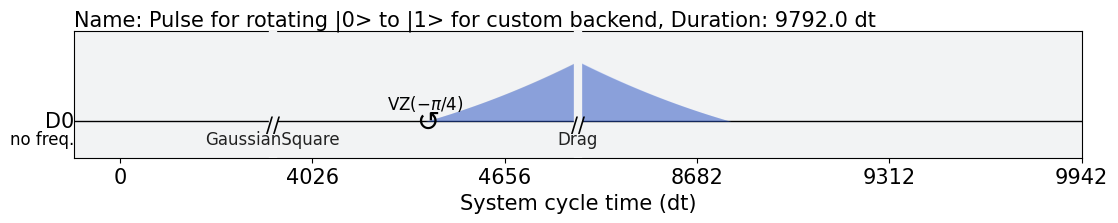

In [293]:
sxp.draw()

Creating circuit construction and fidelity functions to pass to optimizer:

In [294]:
def pulse_circ(amp, sigma_gauss,width, phase_theta, sigma_drag, beta):
    gauss = pulse.library.Gaussian(duration, amp, sig)
    gauss_sq=qiskit.pulse.library.GaussianSquare(duration=duration, amp=amp, sigma=sigma_gauss, width=width,limit_amplitude=False)
    with pulse.build(backend=backend) as sxp:
        with pulse.align_sequential():
            pulse.play(gauss_sq, pulse.DriveChannel(0))
            pulse.shift_phase(phase_theta, pulse.DriveChannel(0))
            pulse.play(pulse.Drag(duration, amp, sigma_drag, beta), pulse.DriveChannel(0))
            pulse.acquire(duration=1000, qubit_or_channel=0, register=pulse.MemorySlot(0))
 #       schedules.append(schedule)
        job = backend.run(sxp, shots=1000)
        result = job.result()
        #schedules.draw()
        return result.get_counts(0)

Check:

In [295]:
pulse_circ(amp,sigma,width,np.pi/6,sig / dt,beta)

{np.str_('0'): np.int64(43), np.str_('1'): np.int64(957)}

In [296]:
def calculate_fidelity_test(pulse_params):
    test=pulse_circ(*pulse_params)
    required_keys = ['0', '1']
    for key in required_keys:
        test.setdefault(key, 0)
    counts = {'0': int(test['0']), '1': int(test['1'])} 

    total_shots = sum(counts.values())
    probabilities = {state: count / total_shots for state, count in counts.items()}
    num_states = 2 
    measured_density_matrix = np.zeros((num_states, num_states), dtype=complex)
    states = ['0','1']  
    for i, state in enumerate(states):
        prob = probabilities.get(state, 0)  # Prob for each state
        # |state><state|
        outer_product = np.outer(np.array([1 if j == i else 0 for j in range(num_states)]), 
                                 np.array([1 if j == i else 0 for j in range(num_states)]))
        measured_density_matrix += prob * outer_product

    #Convert to DensityMatrix object
    rho_measured = DensityMatrix(measured_density_matrix)#measured_density_matrix#DensityMatrix(measured_density_matrix)

    fidelity = state_fidelity(rho_measured, des_state,validate=False)
    infid=1-np.abs(fidelity) 
    #infid_dat.append(infid)
    print('infidelity: '+str(infid))
    return infid 

Check:

In [297]:
t=[amp,sigma,width,np.pi/6,sig / dt,beta]
calculate_fidelity_test(t)

infidelity: 0.03400000000000003


np.float64(0.03400000000000003)

Using above as initial params. Optimize to find optimal params to yield highest probability of flipping from |0> to |1>:

In [111]:
#from scipy.optimize import minimize, Bounds, ADAM
#x0=[0.5,10,0,0.5,10,0]
#bounds=[(1e-5,.99),(None,None),(None,None),(0,2*np.pi),(None,None),(None,None)]
#lower_bounds = [1e-5, 1, 1, 0, 1, 1]
#upper_bounds = [1.0, 1e10, 1e10, np.pi*2, 1e10, 1e10]
#bounds = Bounds(lower_bounds, upper_bounds)
#res = minimize(calculate_fidelity_test, x0=t, method='ADAM', bounds=bounds,
 #              options={'xatol': 1e-2, 'disp': True,'bounds':bounds})

In [107]:
from qiskit_algorithms.optimizers import NFT, ADAM,COBYLA,SciPyOptimizer
#optimizer = NFT(maxiter=10, maxfev=104, disp=True,reset_interval=32,options={'xatol': 1e-2, 'disp': True,'bounds':bounds})
lower_bounds = [1e-5, 1, 1, 0, 1, 1]
upper_bounds = [1.0, 1e10, 1e10, np.pi*2, 1e10, 1e10]
bounds = Bounds(lower_bounds, upper_bounds)
optimizer = ADAM(maxiter=50, lr=0.01, beta_1=0.9, beta_2=0.999, tol=1e-1)
opt_params = optimizer.minimize(calculate_fidelity_test,x0=t,bounds=bounds)

infidelity: 0.03600000000000003
infidelity: 0.03600000000000003
infidelity: 0.04600000000000004
infidelity: 0.03799999999999992
infidelity: 0.040000000000000036
infidelity: 0.04700000000000004
infidelity: 0.03100000000000014
infidelity: 0.04600000000000004


In [108]:
opt_params.x

array([7.42857143e-01, 1.27990000e+02, 1.69000000e+00, 5.13598776e-01,
       1.09902846e+03, 3.51000000e+00])

In [298]:
duration

4396

# Adding above rotation pulse to a 2 qubit system to verify state flipping

Check 0th qubit:

In [347]:
with pulse.build(backend=backend, name='Pulse for rotating |0> to |1> for first qubit w/ custom backend') as sxp:
    with pulse.align_sequential():
        pulse.play(qiskit.pulse.library.GaussianSquare(duration=4396, amp=7.42857143e-01, sigma=1.27990000e+02, width=1.69), pulse.DriveChannel(0))
        pulse.shift_phase(5.13598776e-01, pulse.DriveChannel(0))
        pulse.play(pulse.Drag(4396, 7.42857143e-01, 1.09902846e+03,3.51), pulse.DriveChannel(0))
        pulse.play(qiskit.pulse.library.GaussianSquare(duration=4396, amp=7.42857143e-01, sigma=1.27990000e+02, width=1.69), pulse.DriveChannel(1))
        pulse.shift_phase(5.13598776e-01, pulse.DriveChannel(1))
        pulse.play(pulse.Drag(4396, 7.42857143e-01, 1.09902846e+03,3.51), pulse.DriveChannel(1))
        pulse.acquire(duration=1000, qubit_or_channel=0, register=pulse.MemorySlot(0))
job = backend.run(sxp, shots=100)
result = job.result()
print(result.get_counts())

{np.str_('1'): np.int64(100)}


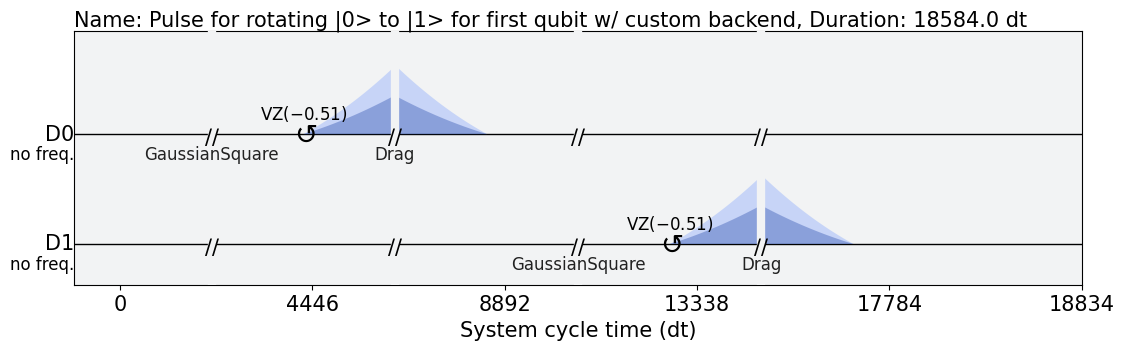

In [348]:
sxp.draw()

Check 1st qubit:

same params for 1st qubit as 0th:

In [367]:
with pulse.build(backend=backend, name='Pulse for rotating |0> to |1> for custom backend') as sxp:
    with pulse.align_sequential():
        pulse.play(qiskit.pulse.library.GaussianSquare(duration=4396, amp=7.42857143e-01, sigma=1.27990000e+02, width=1.69), pulse.DriveChannel(0))
        pulse.shift_phase(5.13598776e-01, pulse.DriveChannel(0))
        pulse.play(pulse.Drag(4396, 7.42857143e-01, 1.09902846e+03,3.51), pulse.DriveChannel(0))
        pulse.play(qiskit.pulse.library.GaussianSquare(duration=4396, amp=7.42857143e-01, sigma=1.27990000e+02, width=1.69), pulse.DriveChannel(1))
        pulse.shift_phase(5.13598776e-01, pulse.DriveChannel(1))
        pulse.play(pulse.Drag(4396, 7.42857143e-01, 1.09902846e+03,3.51), pulse.DriveChannel(1))
        pulse.acquire(duration=1000, qubit_or_channel=1, register=pulse.MemorySlot(0))
        #pulse.measure_all()
job = backend.run(sxp, shots=1000)
result = job.result()
print(result.get_counts())

{np.str_('0'): np.int64(472), np.str_('1'): np.int64(528)}


used same params as first pulse but reduced drag of 1st qubit:

In [368]:
with pulse.build(backend=backend, name='Pulse for rotating |0> to |1> for custom backend') as sxp:
    with pulse.align_sequential():
        pulse.play(qiskit.pulse.library.GaussianSquare(duration=4396, amp=7.42857143e-01, sigma=1.27990000e+02, width=1.69), pulse.DriveChannel(0))
        pulse.shift_phase(5.13598776e-01, pulse.DriveChannel(0))
        pulse.play(pulse.Drag(4396, 7.42857143e-01, 1.09902846e+03,3.51), pulse.DriveChannel(0))
        pulse.play(qiskit.pulse.library.GaussianSquare(duration=4396, amp=7.42857143e-01, sigma=1.27990000e+02, width=1.69), pulse.DriveChannel(1))
        pulse.shift_phase(5.13598776e-01, pulse.DriveChannel(1))
        pulse.play(pulse.Drag(3000, 7.42857143e-01, 1.09902846e+03,3.51), pulse.DriveChannel(1))
        pulse.acquire(duration=1000, qubit_or_channel=1, register=pulse.MemorySlot(0))
        #pulse.measure_all()
job = backend.run(sxp, shots=1000)
result = job.result()
print(result.get_counts())

{np.str_('0'): np.int64(14), np.str_('1'): np.int64(986)}


Seeing if Gaussian params for the 1st qubit can be further optimized

In [371]:
def pulse_circ_2(amp, sigma_gauss,width, phase_theta, sigma_drag, beta):
    gauss = pulse.library.Gaussian(duration, amp, sig)
    gauss_sq=qiskit.pulse.library.GaussianSquare(duration=duration, amp=amp, sigma=sigma_gauss, width=width,limit_amplitude=False)
    with pulse.build(backend=backend, name='Pulse for rotating |0> to |1> for custom backend') as sxp:
        with pulse.align_sequential():
            pulse.play(qiskit.pulse.library.GaussianSquare(duration=4396, amp=7.42857143e-01, sigma=1.27990000e+02, width=1.69), pulse.DriveChannel(0))
            pulse.shift_phase(5.13598776e-01, pulse.DriveChannel(0))
            pulse.play(pulse.Drag(4396, 7.42857143e-01, 1.09902846e+03,3.51), pulse.DriveChannel(0))
            pulse.play(qiskit.pulse.library.GaussianSquare(duration=4396, amp=amp, sigma=sigma_gauss, width=width), pulse.DriveChannel(1))
            pulse.shift_phase(phase_theta, pulse.DriveChannel(1))
            pulse.play(pulse.Drag(3000, amp, sigma_drag, beta), pulse.DriveChannel(1))
            pulse.acquire(duration=1000, qubit_or_channel=1, register=pulse.MemorySlot(0))
 #       schedules.append(schedule)
        job = backend.run(sxp, shots=1000)
        result = job.result()
        #schedules.draw()
        return result.get_counts(0)

def calculate_fidelity_2(pulse_params):
    test=pulse_circ_2(*pulse_params)
    required_keys = ['0', '1']
    for key in required_keys:
        test.setdefault(key, 0)
    counts = {'0': int(test['0']), '1': int(test['1'])} 

    total_shots = sum(counts.values())
    probabilities = {state: count / total_shots for state, count in counts.items()}
    num_states = 2 
    measured_density_matrix = np.zeros((num_states, num_states), dtype=complex)
    states = ['0','1']  
    for i, state in enumerate(states):
        prob = probabilities.get(state, 0)  # Prob for each state
        # |state><state|
        outer_product = np.outer(np.array([1 if j == i else 0 for j in range(num_states)]), 
                                 np.array([1 if j == i else 0 for j in range(num_states)]))
        measured_density_matrix += prob * outer_product

    #Convert to DensityMatrix object
    rho_measured = DensityMatrix(measured_density_matrix)#measured_density_matrix#DensityMatrix(measured_density_matrix)

    fidelity = state_fidelity(rho_measured, des_state,validate=False)
    infid=1-np.abs(fidelity) 
    #infid_dat.append(infid)
    print('infidelity: '+str(infid))
    return infid

Test w/ above parameters (same params as first pulse) to make sure function is working correctly

In [372]:
pulse_circ_2(7.42857143e-01, 1.27990000e+02, 1.69000000e+00, 5.13598776e-01,
       1.09902846e+03, 3.51000000e+00)

{np.str_('0'): np.int64(20), np.str_('1'): np.int64(980)}

Attempting to further optimize:

In [393]:
from qiskit_algorithms.optimizers import NFT, ADAM,COBYLA,SciPyOptimizer
lower_bounds = [1e-5, 1, 1, 0, 1, 1]
upper_bounds = [1.0, 1e10, 1e10, np.pi*2, 1e10, 1e10]
bounds = Bounds(lower_bounds, upper_bounds)
optimizer = ADAM(maxiter=5, lr=0.0001, beta_1=0.9, beta_2=0.999, tol=1e-2)
#optimizer = NFT(maxiter=10, maxfev=1, disp=True)#,reset_interval=32,options={'xatol': 1e-2, 'disp': True,'bounds':bounds})
#optimizer = COBYLA(maxiter=50, tol=1e-2)
opt_params = optimizer.minimize(calculate_fidelity_2,x0=t,bounds=bounds)

infidelity: 0.009000000000000119
infidelity: 0.019999999999999907
infidelity: 0.02200000000000013
infidelity: 0.017000000000000015
infidelity: 0.02200000000000013
infidelity: 0.019999999999999907
infidelity: 0.03100000000000014
infidelity: 0.010000000000000009


In [394]:
opt_params.x

array([7.42757143e-01, 1.27999900e+02, 1.69990000e+00, 5.23498776e-01,
       1.09903836e+03, 3.49990000e+00])

In [395]:
pulse_circ_2(7.42757143e-01, 1.27999900e+02, 1.69990000e+00, 5.23498776e-01,
       1.09903836e+03, 3.49990000e+00)

{np.str_('0'): np.int64(13), np.str_('1'): np.int64(987)}

Take away message: Seems that the gaussian parameters can be effectively identical, however the drags will need to differ.

Pulse schedule with both pulses optimized to flip from |0> to |1>:

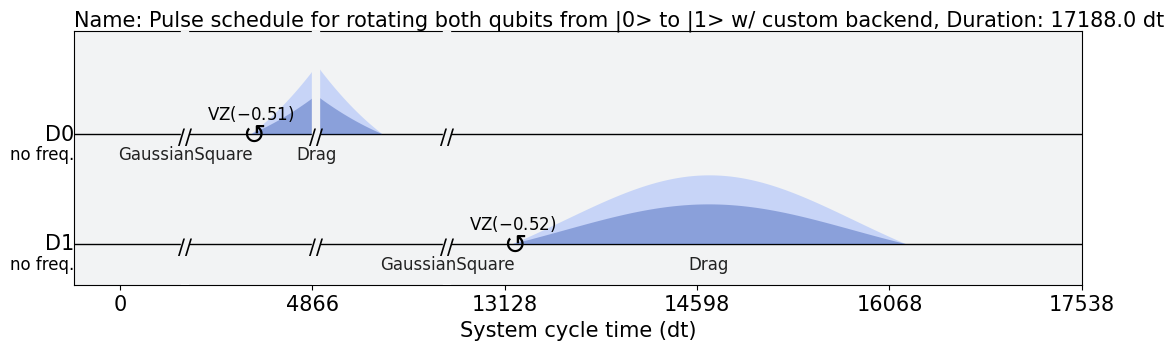

In [400]:
with pulse.build(backend=backend, name='Pulse schedule for rotating both qubits from |0> to |1> w/ custom backend') as sxp:
    with pulse.align_sequential():
        pulse.play(qiskit.pulse.library.GaussianSquare(duration=4396, amp=7.42857143e-01, sigma=1.27990000e+02, width=1.69), pulse.DriveChannel(0))
        pulse.shift_phase(5.13598776e-01, pulse.DriveChannel(0))
        pulse.play(pulse.Drag(4396, 7.42857143e-01, 1.09902846e+03,3.51), pulse.DriveChannel(0))
        pulse.play(qiskit.pulse.library.GaussianSquare(duration=4396, amp=7.42757143e-01, sigma=1.27999900e+02, width=1.69990000e+00), pulse.DriveChannel(1))
        pulse.shift_phase(5.23498776e-01, pulse.DriveChannel(1))
        pulse.play(pulse.Drag(3000, 7.42857143e-01,  1.09903836e+03,3.49990000e+00), pulse.DriveChannel(1))
        pulse.acquire(duration=1000, qubit_or_channel=0, register=pulse.MemorySlot(0))
sxp.draw()

Notes about optimizers:

1. ADAM seems easiest to use for arbitrary circuits - requires a small learning rate but typically avoids issues encountered by other methods like NFT, COBYLA
2. NFT and COBYLA always encounter errors almost immediately with amplitudes exceeding the 1 (see example below). The mentioned flag in the error message below already exists in the pulse scheduler but it doesn't work. It might be part of the old deprecated pulse library and no longer functions correctly

In [396]:
optimizer = NFT(maxiter=10, maxfev=1, disp=True)#,reset_interval=32,options={'xatol': 1e-2, 'disp': True,'bounds':bounds})
#optimizer = COBYLA(maxiter=50, tol=1e-2)
opt_params = optimizer.minimize(calculate_fidelity_2,x0=t,bounds=bounds)

infidelity: 0.017000000000000015


PulseError: 'Maximum pulse amplitude norm exceeds 1.0 with parameters duration=4396, sigma=244.23076923076925, amp=2.3136534696520394, angle=0.0.This can be overruled by setting Pulse.limit_amplitude.'

# Works in progress (not important)

In [274]:
def pulse_circ_2q(amp, sigma_gauss1,width1, phase_theta1, sigma_drag1, beta1,phase_theta2,sigma_gauss2,width2,sigma_drag2,beta2):
    gauss_sq2=qiskit.pulse.library.GaussianSquare(duration=duration, amp=amp, sigma=sigma_gauss2, width=width2)
    with pulse.build(backend=backend) as sxp:
        with pulse.align_sequential():
            pulse.play(gauss_sq1, pulse.DriveChannel(0))
            pulse.shift_phase(phase_theta1, pulse.DriveChannel(0))
            pulse.play(pulse.Drag(duration, amp, sigma_drag1, beta1), pulse.DriveChannel(0))
            pulse.play(gauss_sq2, pulse.DriveChannel(1))
            pulse.shift_phase(phase_theta2,pulse.DriveChannel(1))
            pulse.play(pulse.Drag(duration, amp, sigma_drag2, beta2), pulse.DriveChannel(1))
            #pulse.measure_all()
            pulse.acquire(duration=1000, qubit_or_channel=0, register=pulse.MemorySlot(0))

        job = backend.run(sxp, shots=1000)
        result = job.result()
        #schedules.draw()
        return result.get_counts(0)

In [280]:
t2=[0.1,sigma,width,np.pi/5,sig / dt,beta,sigma,width,0,sig / dt,beta]
pulse_circ_2q(0.1,sigma,width,np.pi,sig / dt,beta,sigma,width,0,sig / dt,beta)

{np.str_('0'): np.int64(685), np.str_('1'): np.int64(315)}

In [288]:
def calculate_fidelity_2q(pulse_params):
    test=pulse_circ_2q(*pulse_params)
    required_keys = ['0', '1']
    for key in required_keys:
        test.setdefault(key, 0)
    counts = {'0': int(test['0']), '1': int(test['1'])} 

    total_shots = sum(counts.values())
    probabilities = {state: count / total_shots for state, count in counts.items()}
    num_states = 2 
    measured_density_matrix = np.zeros((num_states, num_states), dtype=complex)
    states = ['0','1']  
    for i, state in enumerate(states):
        prob = probabilities.get(state, 0)  # Prob for each state
        # |state><state|
        outer_product = np.outer(np.array([1 if j == i else 0 for j in range(num_states)]), 
                                 np.array([1 if j == i else 0 for j in range(num_states)]))
        measured_density_matrix += prob * outer_product

    #Convert to DensityMatrix object
    rho_measured = DensityMatrix(measured_density_matrix)#measured_density_matrix#DensityMatrix(measured_density_matrix)

    fidelity = state_fidelity(rho_measured, des_state,validate=False)
    infid=1-np.abs(fidelity) 
    #infid_dat.append(infid)
    print('infidelity: '+str(infid))
    return infid 

In [289]:
from qiskit_algorithms.optimizers import NFT, ADAM,COBYLA,SciPyOptimizer
#optimizer = NFT(maxiter=10, maxfev=104, disp=True,reset_interval=32,options={'xatol': 1e-2, 'disp': True,'bounds':bounds})
x0=[0.1,sigma,width,np.pi,sig / dt,beta,sigma,width,0,sig / dt,beta]
lower_bounds = [1e-5, 1, 1, 0, 1, 1]
upper_bounds = [1.0, 1e10, 1e10, np.pi*2, 1e10, 1e10]
bounds = Bounds(lower_bounds, upper_bounds)
optimizer = ADAM(maxiter=50, lr=0.01, beta_1=0.9, beta_2=0.999, tol=1e-1)
opt_params = optimizer.minimize(calculate_fidelity_2q,x0=x0,bounds=bounds)

infidelity: 0.725
infidelity: 0.721
infidelity: 0.7070000000000001
infidelity: 0.7110000000000001
infidelity: 0.722
infidelity: 0.724
infidelity: 0.7370000000000001
infidelity: 0.74
infidelity: 0.728
infidelity: 0.7289999999999999
infidelity: 0.7110000000000001
infidelity: 0.734


PulseError: 'Assigned parameters duration=4396, sigma=1.6900000000000002, width=-0.00999999999999992, amp=0.10999999999999993, angle=0.0 violate following constraint: And(0 < sigma, 0 <= width, width <= duration).'

In [284]:
#infid_dat=[]
def calculate_fidelity_2q_4states(pulse_params):
    try:
        test=pulse_circ_2q(*pulse_params)
        required_keys = ['00', '01', '10', '11']
        for key in required_keys:
            test.setdefault(key, 0)
        counts = {'00': int(test['00']), '01': int(test['01']), '10': int(test['10']), '11': int(test['11'])} 
    
        total_shots = sum(counts.values())
        probabilities = {state: count / total_shots for state, count in counts.items()}
        num_states = 4 
        measured_density_matrix = np.zeros((num_states, num_states), dtype=complex)
        states = ['00', '01', '10', '11']  
        for i, state in enumerate(states):
            prob = probabilities.get(state, 0)  # Prob for each state
            # |state><state|
            outer_product = np.outer(np.array([1 if j == i else 0 for j in range(num_states)]), 
                                     np.array([1 if j == i else 0 for j in range(num_states)]))
            measured_density_matrix += prob * outer_product
    
        #Convert to DensityMatrix object
        rho_measured = DensityMatrix(measured_density_matrix)#measured_density_matrix#DensityMatrix(measured_density_matrix)
    
        fidelity = state_fidelity(rho_measured, des_state,validate=False)
        infid=1-np.abs(fidelity) 
        #infid_dat.append(infid)
        print('infidelity: '+str(infid) )
        return infid
    except ZeroDivisionError:
        return np.inf

In [237]:
from qiskit_algorithms.optimizers import NFT, ADAM,COBYLA,SciPyOptimizer
#optimizer = NFT(maxiter=10, maxfev=104, disp=True,reset_interval=32,options={'xatol': 1e-2, 'disp': True,'bounds':bounds})
t2=[0.6,sigma,width,np.pi,sig / dt,beta,sigma,width,np.pi/6,sig / dt,beta]
lower_bounds = [1e-5, 1, 1, 1, 1, 1,1e-5, 1, 1, 1, 1, 1]
upper_bounds = [1.0, 1e5, 1e10, np.pi*2, 1e5, 1e5,1.0, 1e5, 1e5, np.pi*2, 1e5, 1e5]
bounds = Bounds(lower_bounds, upper_bounds)
optimizer = ADAM(maxiter=50, lr=0.01, beta_1=0.9, beta_2=0.999, tol=1e-1)
opt_params = optimizer.minimize(calculate_fidelity_2q,x0=t2,bounds=bounds)

infidelity: 0.566
infidelity: 0.578
infidelity: 0.56
infidelity: 0.537
infidelity: 0.563
infidelity: 0.5459999999999999
infidelity: 0.5880000000000001
infidelity: 0.564
infidelity: 0.5730000000000001
infidelity: 0.5379999999999999
infidelity: 0.552
infidelity: 0.5409999999999999
infidelity: 0.44899999999999995


In [238]:
opt_params.x

array([5.90000000e-01, 1.28010000e+02, 1.71000000e+00, 3.15159265e+00,
       1.09904846e+03, 3.49000000e+00, 1.28010000e+02, 1.69000000e+00,
       5.33598776e-01, 1.09904846e+03, 3.51000000e+00])

In [ ]:
amp1, sigma_gauss1,width1, phase_theta1, sigma_drag1, beta1,phase_theta2,amp2,sigma_gauss2,width2,sigma_drag2,beta2











In [148]:
gauss = pulse.library.Gaussian(duration, amp, sig)
gauss_sq=qiskit.pulse.library.GaussianSquare(duration=duration, amp=amp, sigma=sigma, width=width,limit_amplitude=False)
with pulse.build(backend=backend, name='Pulse for rotating |0> to |1> for custom backend') as sxp:
    with pulse.align_sequential():
        pulse.play(gauss_sq, pulse.DriveChannel(0))
        #pulse.play(pulse.Drag(duration, amp, sig / dt, beta), pulse.DriveChannel(0))
        pulse.shift_phase(np.pi/8, pulse.DriveChannel(0))
        #pulse.play(gauss, pulse.DriveChannel(0))
        pulse.play(pulse.Drag(duration, amp, sig / dt, beta), pulse.DriveChannel(0))
        #pulse.acquire(duration=1000, qubit_or_channel=0, register=pulse.MemorySlot(0))
        #pulse.measure(0,pulse.MeasureChannel(0))
        pulse.play(gauss_sq, pulse.DriveChannel(1))
        #pulse.play(pulse.Drag(duration, amp, sig / dt, beta), pulse.DriveChannel(0))
        pulse.shift_phase(np.pi/6, pulse.DriveChannel(1))
        #pulse.play(gauss, pulse.DriveChannel(0))
        pulse.play(pulse.Drag(duration, amp, sig / dt, beta), pulse.DriveChannel(1))
        #pulse.acquire(duration=1000, qubit_or_channel=1, register=pulse.MemorySlot(0))
        pulse.measure_all()
job = backend.run(sxp, shots=1000)
result = job.result()
print(result.get_counts())

{np.str_('00'): np.int64(8), np.str_('01'): np.int64(413), np.str_('10'): np.int64(17), np.str_('11'): np.int64(562)}


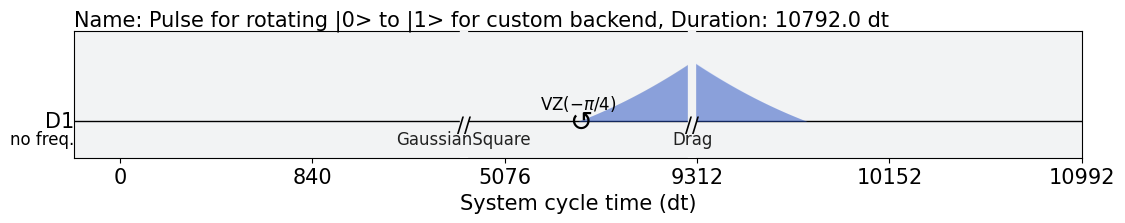

In [147]:
sxp.draw()

# Finding an optimal rotation pulse to rotate a qubit from |00> to |11>

In [143]:
gauss = pulse.library.Gaussian(duration, amp, sig)
gauss_sq=qiskit.pulse.library.GaussianSquare(duration=duration, amp=amp, sigma=sigma, width=width,limit_amplitude=False)
with pulse.build(backend=backend, name='Pulse for rotating |0> to |1> for custom backend') as sxp:
    with pulse.align_sequential():
        pulse.play(gauss_sq, pulse.DriveChannel(0))
        #pulse.play(pulse.Drag(duration, amp, sig / dt, beta), pulse.DriveChannel(0))
        pulse.shift_phase(np.pi/8, pulse.DriveChannel(0))
        #pulse.play(gauss, pulse.DriveChannel(0))
        pulse.play(pulse.Drag(duration, amp, sig / dt, beta), pulse.DriveChannel(0))
        #pulse.acquire(duration=1000, qubit_or_channel=0, register=pulse.MemorySlot(0))
        #pulse.measure(0,pulse.MeasureChannel(0))
        pulse.play(gauss_sq, pulse.DriveChannel(1))
        #pulse.play(pulse.Drag(duration, amp, sig / dt, beta), pulse.DriveChannel(0))
        pulse.shift_phase(np.pi/6, pulse.DriveChannel(1))
        #pulse.play(gauss, pulse.DriveChannel(0))
        pulse.play(pulse.Drag(duration, amp, sig / dt, beta), pulse.DriveChannel(1))
        #pulse.acquire(duration=1000, qubit_or_channel=1, register=pulse.MemorySlot(0))
        pulse.measure_all()
job = backend.run(sxp, shots=1000)
result = job.result()
print(result.get_counts())

{np.str_('00'): np.int64(10), np.str_('01'): np.int64(427), np.str_('10'): np.int64(13), np.str_('11'): np.int64(550)}


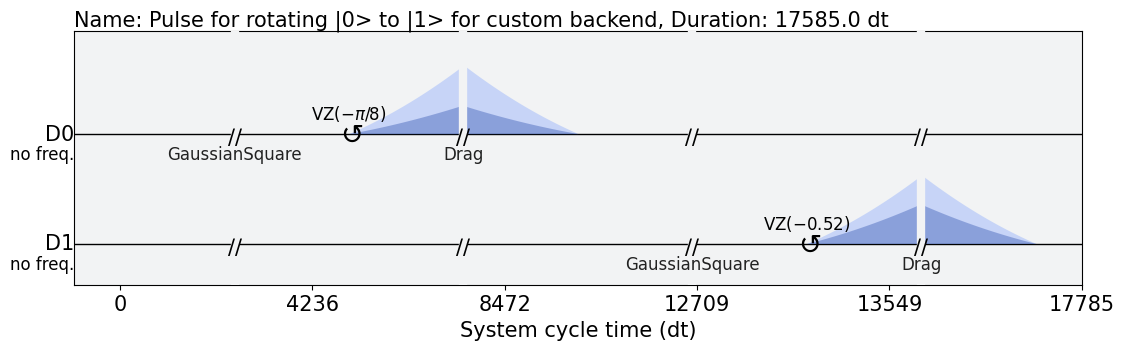

In [144]:
sxp.draw()

In [402]:
def rotation(channel):
    pulse.play(qiskit.pulse.library.GaussianSquare(duration=4396, amp=7.42857143e-01, sigma=1.27990000e+02, width=1.69), pulse.DriveChannel(0))
    pulse.play(pulse.shift_phase(5.13598776e-01), pulse.DriveChannel(0))
    pulse.play(pulse.Drag(4396, 7.42857143e-01, 1.09902846e+03,3.51), pulse.DriveChannel(0))
#rot0to1_13=qiskit.pulse.library.GaussianSquare(duration=4396, amp=7.42857143e-01, sigma=1.27990000e+02, width=1.69)
#rot0to1_23=pulse.shift_phase(5.13598776e-01)
#rot0to1_33=pulse.Drag(4396, 7.42857143e-01, 1.09902846e+03,3.51)



def shift_phase_on_channel(pulse, phase_shift, channel=None):
    if channel is None:
        pulse.shift_phase(phase_shift)
    else:
        pulse.shift_phase(phase_shift, channel)